In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from scipy.stats import boxcox
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm_notebook
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')


## Задача
1. Постройте его модель ARIMA.

## Загрузка временного ряда

In [156]:
PATH_SERIES = '../../src/time_line_1/Series/'
mean_monthly_temp = pd.read_csv(PATH_SERIES + "mean-monthly-air-temperature-deg.csv").Deg
mean_monthly_temp

0      40.6
1      40.8
2      44.4
3      46.7
4      54.1
       ... 
235    61.8
236    58.2
237    46.7
238    46.6
239    37.8
Name: Deg, Length: 240, dtype: float64

In [157]:
# функция возвращает значения статистик для теста Дики-Фуллера

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Пример использования
test_stationarity(mean_monthly_temp)

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


In [158]:
mean_monthly_temp_diff = mean_monthly_temp.diff().dropna()

# Проверка стационарности после дифференцирования
test_stationarity(mean_monthly_temp_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.225927e+01
p-value                        9.157883e-23
#Lags Used                     1.100000e+01
Number of Observations Used    2.270000e+02
Critical Value (1%)           -3.459490e+00
Critical Value (5%)           -2.874358e+00
Critical Value (10%)          -2.573602e+00
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                -1.225927e+01
p-value                        9.157883e-23
#Lags Used                     1.100000e+01
Number of Observations Used    2.270000e+02
Critical Value (1%)           -3.459490e+00
Critical Value (5%)           -2.874358e+00
Critical Value (10%)          -2.573602e+00
dtype: float64


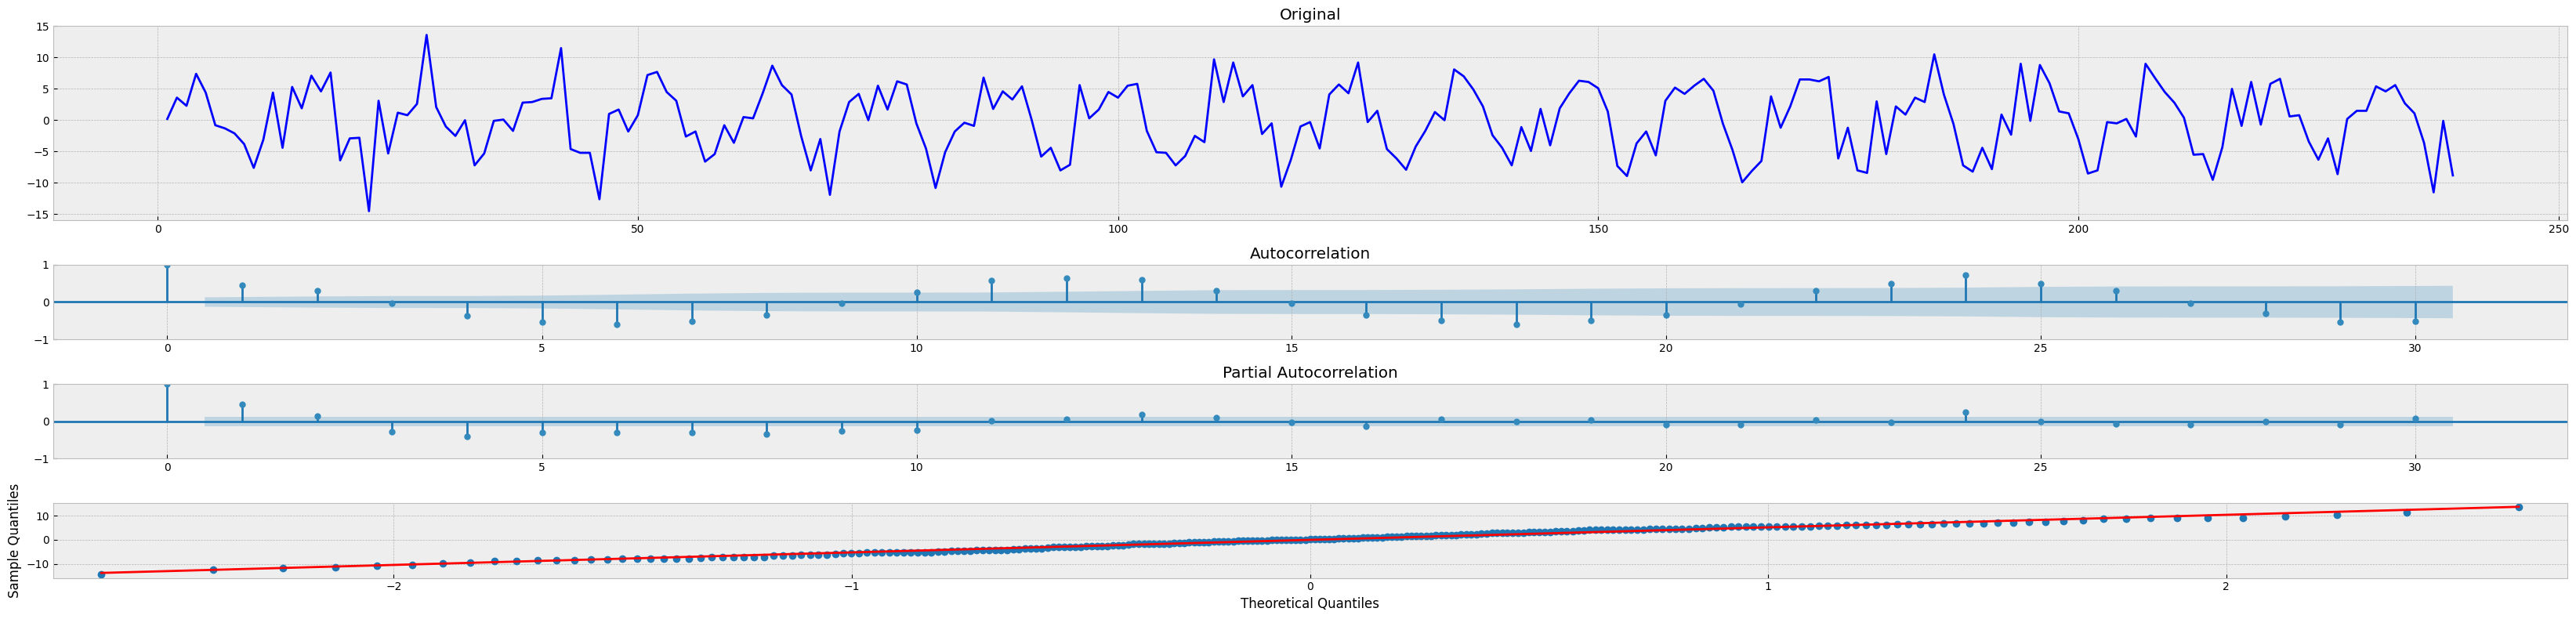

In [159]:
def tsplot(y, lags=None, figsize=(33, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Original')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()

tsplot(mean_monthly_temp_diff, lags=30)

Подбор параметров модели ARIMA

In [160]:
# Подбор параметров модели ARIMA
from statsmodels.tsa.arima.model import ARIMA
from tqdm.notebook import tqdm_notebook

best_aic = np.inf 
best_order = None
best_mdl = None
best_trend = None

trends = ['c', 't'] # проверки как константного ('c'), так и линейного ('t') трендов

for trend in trends:
    for i in tqdm_notebook(range(5)):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = ARIMA(mean_monthly_temp, order=(i, d, j), trend=trend).fit()
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                        best_trend = trend
                except:
                    continue

print('aic: {:6.5f} | order: {} | trend: {}'.format(best_aic, best_order, best_trend))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

aic: 1136.12229 | order: (3, 0, 2) | trend: c


Визуализация остатков модели

Results of Dickey-Fuller Test:
Test Statistic                  -5.633131
p-value                          0.000001
#Lags Used                       5.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


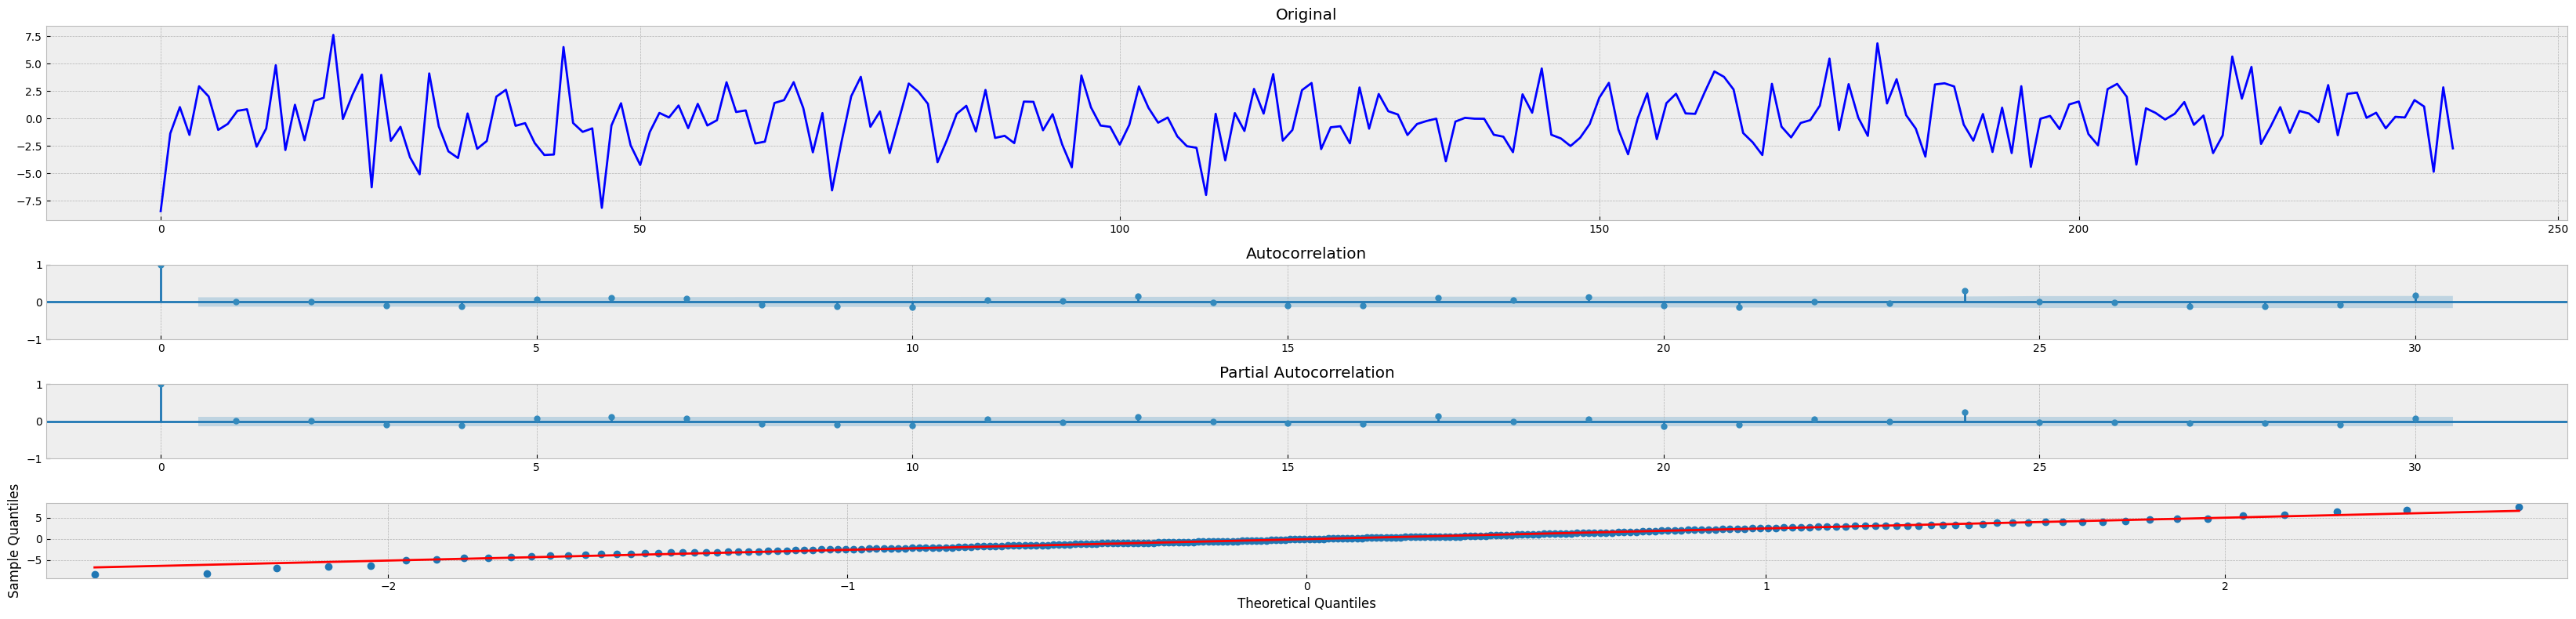

In [161]:
tsplot(best_mdl.resid, lags=30)

Прогнозирование и визуализация

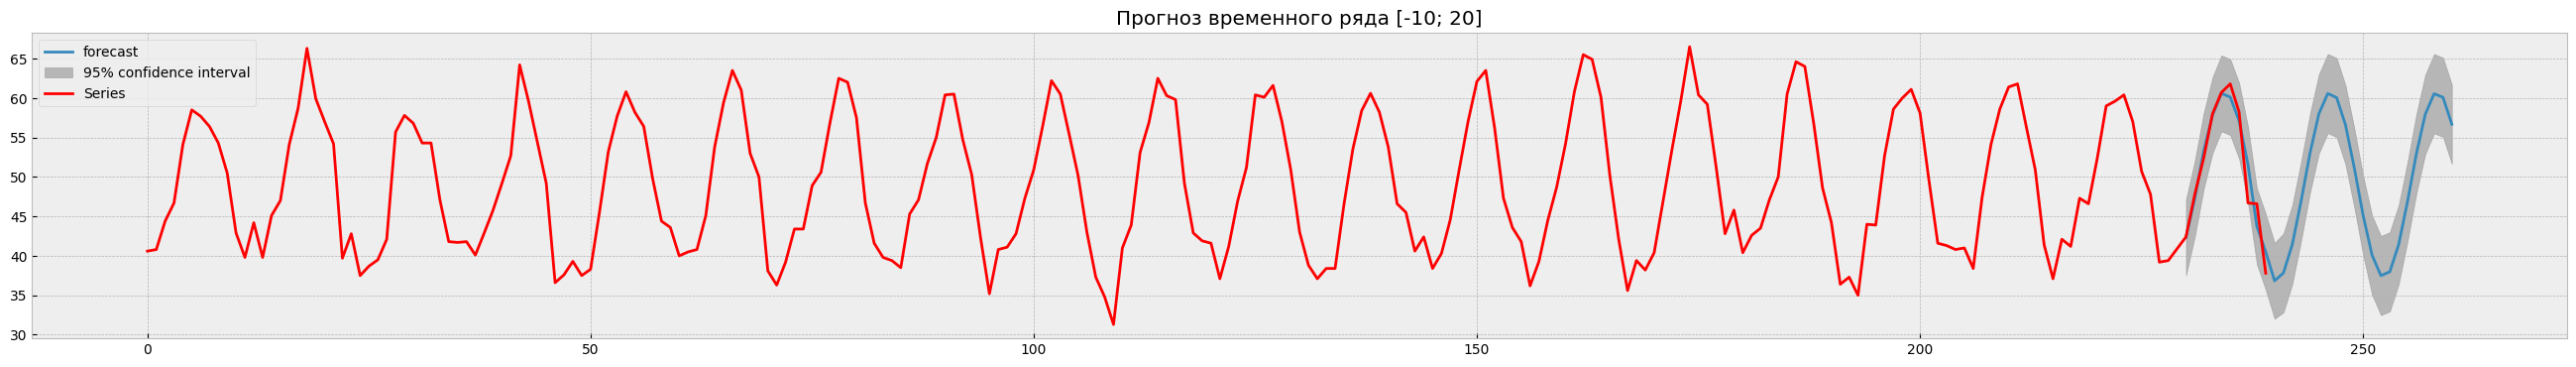

In [162]:
from statsmodels.graphics.tsaplots import plot_predict

with plt.style.context('bmh'):
    plt.figure(figsize=(33, 4))
    ax = plt.axes()
    plot_predict(best_mdl, start=len(mean_monthly_temp)-10, end=len(mean_monthly_temp)+20, ax=ax)
    plt.plot(mean_monthly_temp, color='red', label='Series')
    plt.title("Прогноз временного ряда [-10; 20]")
    plt.legend()
    plt.show()

## Вывод

+ Загрузил данные
+ Провел тест на стационарность временного ряда
+ Использовал перебор параметров ARIMA для нахождения модели с наименьшим значением AIC и два типа тренда: константный и линейный
+ Построил графики остатков лучшей модели для проверки их случайности и стационарности
+ Сделал прогнозирование на 20 периодов вперед и визуализировал результаты вместе с оригинальным временным рядом